## Выбор функции

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

Данные

In [2]:
data= pd.read_csv('../../data/churn_modelling.csv')
data.head()

,CustomerId,CredRate,Geography,Gender,Age,Tenure,Balance,Prod Number,HasCrCard,ActMem,EstimatedSalary,Exited
0,15634602,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0


In [3]:
data.dtypes

CustomerId           int64
CredRate             int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
Prod Number          int64
HasCrCard            int64
ActMem               int64
EstimatedSalary    float64
Exited               int64
dtype: object

Преобразуем типы данных

In [4]:
data["Geography"] = data["Geography"].astype('category').cat.codes
data["Gender"] = data["Gender"].astype('category').cat.codes
data["HasCrCard"] = data["HasCrCard"].astype('category').cat.codes
data["Churn"] = data["Exited"].astype('category').cat.codes

data.drop('Exited', axis=1, inplace=True)

In [5]:
data.dtypes

CustomerId           int64
CredRate             int64
Geography             int8
Gender                int8
Age                float64
Tenure               int64
Balance            float64
Prod Number          int64
HasCrCard             int8
ActMem               int64
EstimatedSalary    float64
Churn                 int8
dtype: object

Проверить на пропущенные значения

In [6]:
data.isna().any()

CustomerId         False
CredRate           False
Geography          False
Gender             False
Age                 True
Tenure             False
Balance            False
Prod Number        False
HasCrCard          False
ActMem             False
EstimatedSalary     True
Churn              False
dtype: bool

In [7]:
data['EstimatedSalary']=data['EstimatedSalary'].fillna(data['EstimatedSalary'].mean()) 

In [16]:
data['Age']=data['Age'].fillna(data['Age'].mode()[0])

In [17]:
data.isna().any()

CustomerId         False
CredRate           False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
Prod Number        False
HasCrCard          False
ActMem             False
EstimatedSalary    False
Churn              False
dtype: bool

Разделить данные на тестовые и тренировочные

In [18]:
target = 'Churn'
X = data.drop('Churn', axis=1)
y=data[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,
                                    random_state=123,
                                    stratify=y) 

In [19]:
forest = RandomForestClassifier(n_estimators=500, random_state=1)

In [20]:
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

Важные функции

In [21]:
importances=forest.feature_importances_

Все функции кроме целевой

In [24]:
features = data.drop(['Churn'],axis=1).columns

Отсортируем функции по важности

In [25]:
indices = np.argsort(importances)[::-1]

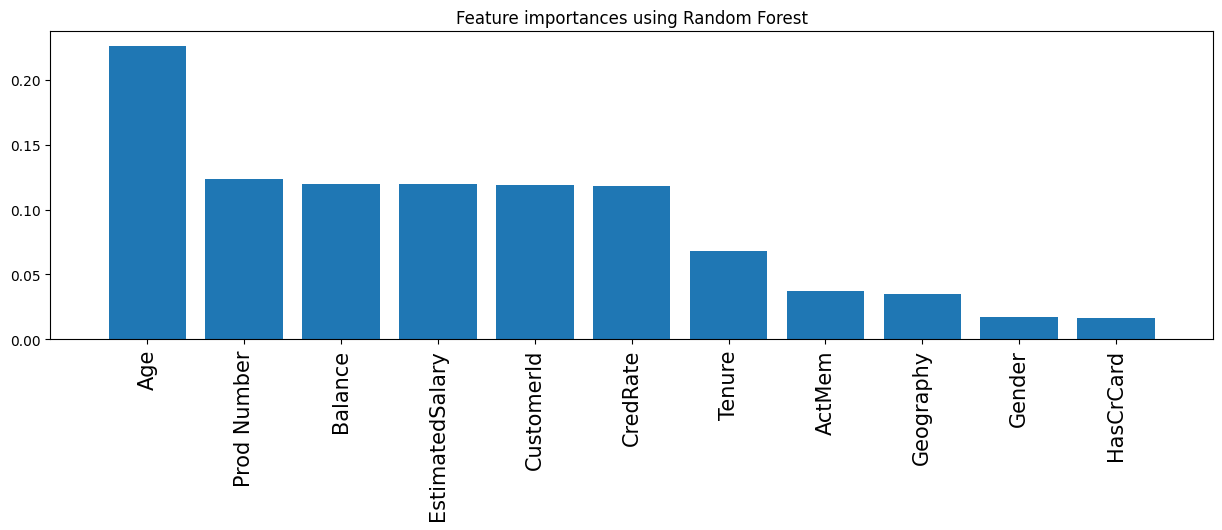

In [27]:
plt.figure(figsize=(15,4)) 
plt.title("Feature importances using Random Forest") 
plt.bar(range(X_train.shape[1]), importances[indices], align="center") 
plt.xticks(range(X_train.shape[1]), features[indices], rotation='vertical', fontsize=15) 
plt.xlim([-1, X_train.shape[1]])
plt.show() 

In [28]:
feature_importance_df = pd.DataFrame({"Feature": features,
                                      "Importance": importances}) 

In [35]:
feature_importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
4,Age,0.225891
7,Prod Number,0.123847
6,Balance,0.119866
10,EstimatedSalary,0.119759
0,CustomerId,0.118782
1,CredRate,0.117939
5,Tenure,0.067702
9,ActMem,0.037520
2,Geography,0.034871
3,Gender,0.017245


## Построение логистической модели

In [46]:
from typing import NewType

import statsmodels.api as sm 

In [38]:
top5_features = ['Age','EstimatedSalary','CredRate', 'Balance','Prod Number'] 
logReg = sm.Logit(y_train, X_train[top5_features]) 
logistic_regression = logReg.fit() 

Optimization terminated successfully.
         Current function value: 0.472882
         Iterations 6


Сводка параметров

In [44]:
logistic_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 8500
Model:                          Logit   Df Residuals:                     8495
Method:                           MLE   Df Model:                            4
Date:                Mon, 06 Feb 2023   Pseudo R-squ.:                 0.06437
Time:                        21:20:47   Log-Likelihood:                -4019.5
converged:                       True   LL-Null:                       -4296.0
Covariance Type:            nonrobust   LLR p-value:                2.199e-118
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Age                 0.0483      0.002     20.655      0.000       0.044       0.053
EstimatedSalary -1.028e-06   4.77e-07     -2.156      0.031   -1.96e-06   -9.34e-08
CredRate           -0.0045      0.000    -23.381      0.000      -0.005      -0.004
Balance          2.884e-06   4.62e-07      6.245      0.000    1.98e-06    3.79e-06
Prod Number        -0.3617      0.048     -7.599      0.000      -0.455      -0.268
===================================================================================
"""

Коэффициенты регрессионной модели

EstimatedSalary, Balance оказывают гораздо меньшее влияние на целевую переменную, чем все остальные

In [43]:
logistic_regression.params

Age                0.048335
EstimatedSalary   -0.000001
CredRate          -0.004470
Balance            0.000003
Prod Number       -0.361678
dtype: float64

In [45]:
type(logistic_regression.params)

pandas.core.series.Series

In [63]:
coef = logistic_regression.params

FunctionCoefficients = NewType('FunctionCoefficients', pd.Series)

def churn_probability(coef: FunctionCoefficients,
                      Age: int,
                      EstimatedSalary: float,
                      CreditRate: int,
                      Balance: float,
                      Prod_number: int) -> float:
    """Logistic regression equation"""
    return coef[0]*Age + coef[1]*EstimatedSalary + coef[2]*CreditRate \
        + coef[3]*Balance + coef[4]*Prod_number

Пример расчета вероятности ухода конкретного клиента

In [64]:
cp = churn_probability(coef, 50, 100000, 600, 100000, 2)
print(np.exp(cp)/(1 + np.exp(cp)))

0.3093646023640838


### Логистическая регрессия для определения того, насколько точна модель на тестовых данных

In [58]:
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train[top5_features], y_train) 

Предсказания

In [59]:
clf.predict(X_test[top5_features])

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

Оценка вероятности

[0.61565033, 0.38434967] - 61.5% что клиент останется; 38,4% что уйдет

In [60]:
clf.predict_proba(X_test[top5_features])

array([[0.61565033, 0.38434967],
       [0.76717157, 0.23282843],
       [0.78137389, 0.21862611],
       ...,
       [0.552548  , 0.447452  ],
       [0.85311964, 0.14688036],
       [0.75851722, 0.24148278]])

Точность на тестовом наборе даных

In [61]:
clf.score(X_test[top5_features], y_test)

0.79